# Building and Testing the performance of different models for the "Occupation Quota" of a Parisian street

## ----------------------------------- Data loading and Preprocessing -----------------------------------

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import time
import os
import tqdm.notebook as tq
import tensorflow as tf
import warnings
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')

#### Connect to Google Drive to get access to data later on

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/'Dossier partagé avec Iheb BELGACEM'/BCG_Hackathon

/content/drive/.shortcut-targets-by-id/1yXfewQDE3qy07N5B0XsOVSfqgaaXT3R7/Dossier partagé avec Iheb BELGACEM/BCG_Hackathon


#### Load dataframe and start preprocessing

In [6]:
data_path = "datasets/wash1.csv"
TARGET = "Taux d'occupation"
#TARGET = "Débit horaire"
dataframe = pd.read_csv(data_path)
dataframe.drop(["Unnamed: 0","index"], axis = 1 , inplace= True)
def set_date(df):
    df["Date et heure de comptage"] = pd.to_datetime(df["Date et heure de comptage"],format='%Y-%m-%d %H:%M:%S%z')
    return df
dataframe = set_date(dataframe)
dataframe.time = dataframe.time.apply(lambda x : int(x[:2]))
if TARGET == "Taux d'occupation": 
  dataframe.drop(["Débit horaire","mean_debit_horaire_past_week","debit_horaire_past_week"], axis = 1 , inplace= True)
else : 
  dataframe.drop(["Taux d'occupation","mean_taux_occupation_past_week","taux_occupation_past_week"], axis = 1 , inplace= True)
dataframe.drop(["Etat trafic","Libelle noeud amont","Libelle noeud aval","date"], axis = 1 , inplace= True)
dataframe

,Date et heure de comptage,Taux d'occupation,weekday,weekofyear,month,year,time,temp,dwpt,rhum,tavg,tmin,tmax,pres,mean_taux_occupation_past_week,taux_occupation_past_week,taux_occupation_sae,retail_and_recreation_percent_change_from_baseline,confin_0,confin_1,confin_2,couvrefeu,ferie
0,2019-11-14 04:00:00+01:00,3.20167,3,46,11,2019,4,5.1,4.2,94.0,5.6,4.6,6.5,997.9,15.835636,5.89833,12.289109,96.0,1,0,0,0,0
1,2019-11-14 05:00:00+01:00,3.27389,3,46,11,2019,5,5.3,4.3,93.0,5.6,4.6,6.5,997.9,15.809154,2.29278,12.289109,96.0,1,0,0,0,0
2,2019-11-14 06:00:00+01:00,5.28222,3,46,11,2019,6,5.5,3.3,86.0,5.6,4.6,6.5,997.9,15.828470,6.15222,12.289109,96.0,1,0,0,0,0
3,2019-11-14 07:00:00+01:00,9.07722,3,46,11,2019,7,5.2,3.4,88.0,5.6,4.6,6.5,997.9,15.854842,7.03278,12.289109,96.0,1,0,0,0,0
4,2019-11-14 08:00:00+01:00,15.51111,3,46,11,2019,8,5.2,3.5,89.0,5.6,4.6,6.5,997.9,15.900355,12.87889,12.289109,96.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,2020-11-29 20:00:00+01:00,13.09667,6,48,11,2020,20,1.0,-0.9,87.0,2.5,1.0,6.0,1023.0,5.704904,9.45389,72.933663,34.0,0,0,1,0,0
9332,2020-11-29 21:00:00+01:00,7.50778,6,48,11,2020,21,1.0,-0.9,87.0,2.5,1.0,6.0,1023.0,5.720698,4.75833,72.933663,34.0,0,0,1,0,0
9333,2020-11-29 22:00:00+01:00,4.38000,6,48,11,2020,22,2.0,0.1,87.0,2.5,1.0,6.0,1023.0,5.733952,2.91389,72.933663,34.0,0,0,1,0,0
9334,2020-11-29 23:00:00+01:00,2.11500,6,48,11,2020,23,2.0,0.1,87.0,2.5,1.0,6.0,1023.0,5.743793,1.89722,72.933663,34.0,0,0,1,0,0


In [7]:
dataframe = dataframe.interpolate() #get rid of NaN values
#dataframe

In [8]:
dataframe.columns

Index(['Date et heure de comptage', 'Taux d'occupation', 'weekday',
       'weekofyear', 'month', 'year', 'time', 'temp', 'dwpt', 'rhum', 'tavg',
       'tmin', 'tmax', 'pres', 'mean_taux_occupation_past_week',
       'taux_occupation_past_week', 'taux_occupation_sae',
       'retail_and_recreation_percent_change_from_baseline', 'confin_0',
       'confin_1', 'confin_2', 'couvrefeu', 'ferie'],
      dtype='object')

In [9]:
feat_time = ['weekday','weekofyear', 'month', 'year', 'time']
feat_meteo_d = ['tmin', 'tmax']
feat_meteo_h = ['temp', 'dwpt', 'rhum']
feat_conf_fer = ['confin_0','confin_1', 'confin_2', 'couvrefeu', 'ferie']
feat_mean = ['mean_taux_occupation_past_week'] if TARGET =="Taux d'occupation" else ['mean_debit_horaire_past_week']
feat_pastweek = ["taux_occupation_past_week"] if TARGET =="Taux d'occupation" else ['debit_horaire_past_week']
feat_google = ['retail_and_recreation_percent_change_from_baseline']
feat_covid = ['taux_occupation_sae']

In [10]:
split_rate = 0.8
i_split = int(dataframe.shape[0] * split_rate)
df_train = dataframe[:i_split]
df_test = dataframe[i_split:]
tt = df_test['Date et heure de comptage']

## ----------------------------------- Building and Testing of several models -----------------------------------



Regression Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model_name = "Random_Forest_Regression_f"
if model_name not in os.listdir(os.getcwd()) : 
  os.mkdir(model_name)
  print('Created Folder')

In [ ]:
experiments = [feat_time+feat_mean , feat_time+feat_mean+feat_meteo_d , feat_time+feat_mean+feat_conf_fer,
               feat_time+feat_mean+feat_meteo_d+feat_conf_fer, feat_time+feat_mean+feat_meteo_h+feat_conf_fer,
               feat_time+feat_mean+feat_google, feat_time+feat_mean+feat_meteo_d+feat_google, feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_google,
               feat_time+feat_mean+feat_covid, feat_time+feat_mean+feat_meteo_d+feat_covid, feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_covid,
               feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_covid+feat_google]

In [ ]:
count = 1
resume = []
for leaf in [5,6,7,8,9,10] : 
  for e in tq.tqdm(experiments) : 
    time.sleep(1)
    timestep = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
    os.mkdir(os.path.join(os.getcwd(),model_name,timestep))
    x_train =  df_train[e].values
    x_test = df_test[e].values
    y_train = df_train[TARGET].values
    y_test = df_test[TARGET].values
    model = RandomForestRegressor(min_samples_leaf=leaf)
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    mse_tot = mean_squared_error(y_test,pred)
    mse_first = mean_squared_error(y_test[:24*6],pred[:24*6])
    record = {'name' : timestep , 'features' : e, "mse_tot":mse_tot , "mse_first" :mse_first , "min_samples_leaf" : leaf, "path": os.path.join(os.getcwd(), model_name, timestep)}
    resume.append(record)
    pd.DataFrame.from_records([record]).to_csv(os.path.join(os.getcwd(),model_name,timestep,timestep+".csv"))
    fig = plt.figure(count)
    count = count + 1
    plt.plot(tt, y_test , color = 'r',label = 'real values')
    plt.plot(tt, pred , color ='b',label = 'prediected values')
    plt.title(model_name + "  ||  The MSE_tot: {}".format(mse_tot))
    fig.savefig(os.path.join(os.getcwd(),model_name,timestep,'total'+timestep+'.jpeg'))
    fig = plt.figure(count)
    count = count +1 
    plt.plot(tt[:24*6], y_test[:24*6] , color = 'r',label = 'real values')
    plt.plot(tt[:24*6], pred[:24*6] , color = 'b',label = 'predicted values')
    plt.title(model_name + "  ||  The MSE_first_6days: {}".format(mse_first))
    fig.savefig(os.path.join(os.getcwd(), model_name,timestep,'first'+timestep+'.jpeg'))
  pd.DataFrame.from_records(resume).sort_values('mse_tot').to_csv(model_name+".csv")


Output hidden; open in https://colab.research.google.com to view.

In [19]:
model_name = "Random_Forest_Regression_f"
resume = pd.read_csv(model_name+'.csv')
del resume['Unnamed: 0']
resume

,name,features,mse_tot,mse_first,min_samples_leaf,path
0,2020-12-09 12_42_49,"['weekday', 'weekofyear', 'month', 'year', 'ti...",25.029792,23.673019,10,/content/drive/.shortcut-targets-by-id/1yXfewQ...
1,2020-12-09 12_41_44,"['weekday', 'weekofyear', 'month', 'year', 'ti...",25.069655,23.644620,8,/content/drive/.shortcut-targets-by-id/1yXfewQ...
2,2020-12-09 12_40_39,"['weekday', 'weekofyear', 'month', 'year', 'ti...",25.203080,22.869132,6,/content/drive/.shortcut-targets-by-id/1yXfewQ...
3,2020-12-09 12_41_12,"['weekday', 'weekofyear', 'month', 'year', 'ti...",25.425141,22.699284,7,/content/drive/.shortcut-targets-by-id/1yXfewQ...
4,2020-12-09 12_42_16,"['weekday', 'weekofyear', 'month', 'year', 'ti...",26.115026,23.943425,9,/content/drive/.shortcut-targets-by-id/1yXfewQ...
...,...,...,...,...,...,...
67,2020-12-09 12_42_00,"['weekday', 'weekofyear', 'month', 'year', 'ti...",60.937166,22.657616,9,/content/drive/.shortcut-targets-by-id/1yXfewQ...
68,2020-12-09 12_40_24,"['weekday', 'weekofyear', 'month', 'year', 'ti...",60.985368,25.552824,6,/content/drive/.shortcut-targets-by-id/1yXfewQ...
69,2020-12-09 12_40_58,"['weekday', 'weekofyear', 'month', 'year', 'ti...",61.480774,26.901719,7,/content/drive/.shortcut-targets-by-id/1yXfewQ...
70,2020-12-09 12_40_55,"['weekday', 'weekofyear', 'month', 'year', 'ti...",62.159788,21.540387,7,/content/drive/.shortcut-targets-by-id/1yXfewQ...


In [20]:
for i in range(len(resume)) : 
  print(i)
  print("MSE_tot: {}    ||     Features: {}".format( str(resume.loc[i,"mse_tot"]), resume.loc[i,'features']))

0
MSE_tot: 25.029791564332147    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'taux_occupation_sae']
1
MSE_tot: 25.069654519810086    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'taux_occupation_sae']
2
MSE_tot: 25.20307961669273    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'taux_occupation_sae']
3
MSE_tot: 25.425141435626074    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'taux_occupation_sae']
4
MSE_tot: 26.115025848790626    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'taux_occupation_sae']
5
MSE_tot: 26.46957061789876    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'tmin', 'tmax', 'taux_occupation_sae']
6
MSE_tot: 26.47789837141718    ||    

name                                              2020-12-09 12_41_23
features            ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                       53.6286
mse_first                                                     20.9025
min_samples_leaf                                                    8
path                /content/drive/.shortcut-targets-by-id/1yXfewQ...
Name: 41, dtype: object
['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week']


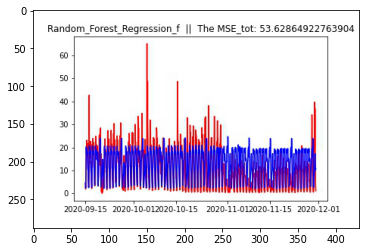

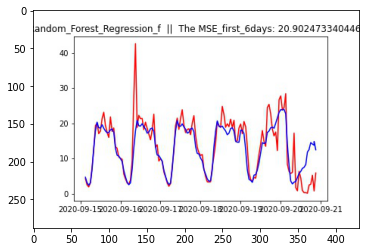

In [21]:
for i in [41] : 
  print(resume.loc[i])
  print(resume.loc[i,"features"])
  path = resume.loc[i,"path"]
  for file in os.listdir(path) : 
    if '.jpeg' in file : 
      img = mpimg.imread(os.path.join(resume.loc[i,'path'],file))
      plt.imshow(img)
      plt.show()


# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------





Support Vector Regression - SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
model_name = "Support_Vector_Regression"
if model_name not in os.listdir(os.getcwd()) : 
  os.mkdir(model_name)
  print('Created Folder')

In [ ]:
experiments = [feat_time+feat_mean , feat_time+feat_mean+feat_meteo_d , feat_time+feat_mean+feat_conf_fer,
               feat_time+feat_mean+feat_meteo_d+feat_conf_fer, feat_time+feat_mean+feat_meteo_h+feat_conf_fer,
               feat_time+feat_mean+feat_google, feat_time+feat_mean+feat_meteo_d+feat_google, feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_google,
               feat_time+feat_mean+feat_covid, feat_time+feat_mean+feat_meteo_d+feat_covid, feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_covid,
               feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_covid+feat_google]

In [ ]:
count = 1
resume = []

for kernel in tq.tqdm( ['rbf', 'poly', 'sigmoid', 'linear'] ):
  for degree in tq.tqdm( [2, 3, 4, 5] ):
    
    for inv_generalization in tq.tqdm( [100.0, 200.0] ):
      for e in tq.tqdm(experiments) : 
        timestep = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
        os.mkdir(os.path.join(os.getcwd(),model_name,timestep))
        x_train =  df_train[e].values
        x_test = df_test[e].values
        y_train = df_train[TARGET].values
        y_test = df_test[TARGET].values


        model = make_pipeline(StandardScaler(), SVR(kernel = kernel, degree = degree, tol = 0.001, C=inv_generalization, epsilon=0.01, max_iter = -1))
        model.fit(x_train,y_train)

        pred = model.predict(x_test)
        mse_tot = mean_squared_error(y_test,pred)
        mse_first = mean_squared_error(y_test[:24*6],pred[:24*6])
        record = {'name' : timestep , 'features' : e, "mse_tot":mse_tot , "mse_first" :mse_first , "kernel": kernel, "degree": degree, "inv_generalization": inv_generalization, "path": os.path.join(os.getcwd(), model_name, timestep)}
        resume.append(record)
        pd.DataFrame.from_records([record]).to_csv(os.path.join(os.getcwd(),model_name,timestep,timestep+".csv"))
        fig = plt.figure(count)
        count = count + 1
        plt.plot(tt, y_test , color = 'r',label = 'real values')
        plt.plot(tt, pred , color ='b',label = 'prediected values')
        plt.title(model_name + "  ||  The MSE_tot: {}".format(mse_tot))
        fig.savefig(os.path.join(os.getcwd(),model_name,timestep,'total'+timestep+'.jpeg'))
        fig = plt.figure(count)
        count = count +1 
        plt.plot(tt[:24*6], y_test[:24*6] , color = 'r',label = 'real values')
        plt.plot(tt[:24*6], pred[:24*6] , color = 'b',label = 'predicted values')
        plt.title(model_name + "  ||  The MSE_first_6days: {}".format(mse_first))
        fig.savefig(os.path.join(os.getcwd(), model_name,timestep,'first'+timestep+'.jpeg'))
    pd.DataFrame.from_records(resume).sort_values('mse_tot').to_csv(model_name+".csv")
resume = pd.read_csv(model_name+'.csv')
del resume['Unnamed: 0']

In [ ]:
resume

NameError: ignored

In [ ]:
for i in range(5) : 
  print(i)
  print("MSE_tot: {}    ||     Features: {}".format( str(resume.loc[i,"mse_tot"]), resume.loc[i,'features']))

0
MSE_tot: 46.297831445154934    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'retail_and_recreation_percent_change_from_baseline']
1
MSE_tot: 56.31013392361002    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'tavg', 'tmin', 'tmax', 'pres', 'retail_and_recreation_percent_change_from_baseline']
2
MSE_tot: 59.33971966863413    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'tavg', 'tmin', 'tmax', 'pres', 'confin_0', 'confin_1', 'confin_2', 'couvrefeu', 'ferie', 'taux_occupation_sae', 'retail_and_recreation_percent_change_from_baseline']
3
MSE_tot: 64.84569134323003    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week', 'tavg', 'tmin', 'tmax', 'pres', 'confin_0', 'confin_1', 'confin_2', 'couvrefeu', 'ferie', 'retail_and_recreation_percent_change_from_baseline']
4
MSE_tot: 6

name                                       2020-12-08 23_34_53
features     ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                46.2978
mse_first                                              36.3466
path         /content/drive/My Drive/Dossier partagé avec ...
Name: 0, dtype: object


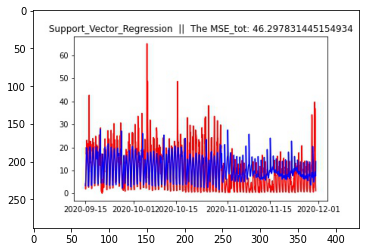

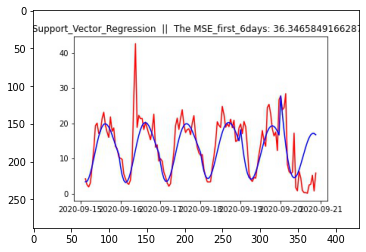

name                                       2020-12-08 23_35_01
features     ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                56.3101
mse_first                                              46.7822
path         /content/drive/My Drive/Dossier partagé avec ...
Name: 1, dtype: object


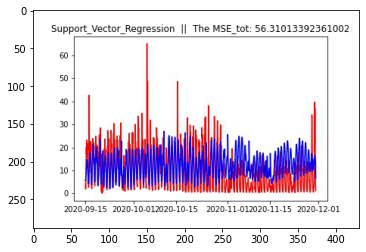

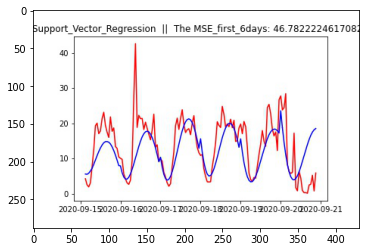

name                                       2020-12-08 23_35_46
features     ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                59.3397
mse_first                                              46.6047
path         /content/drive/My Drive/Dossier partagé avec ...
Name: 2, dtype: object


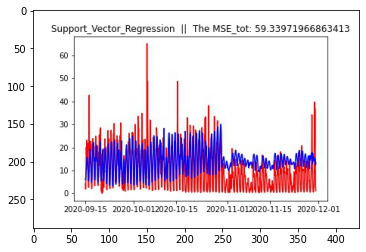

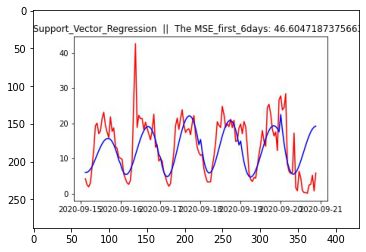

name                                       2020-12-08 23_35_10
features     ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                64.8457
mse_first                                              48.7441
path         /content/drive/My Drive/Dossier partagé avec ...
Name: 3, dtype: object


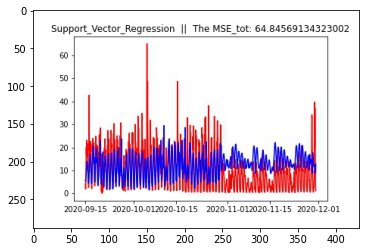

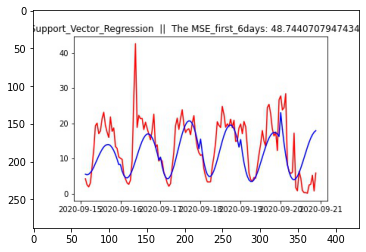

name                                       2020-12-08 23_35_37
features     ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                  69.36
mse_first                                              48.3104
path         /content/drive/My Drive/Dossier partagé avec ...
Name: 4, dtype: object


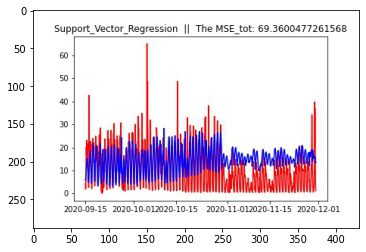

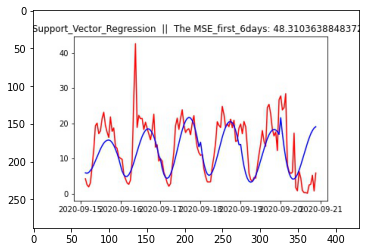

In [ ]:
for i in range(5) : 
  print(resume.loc[i])
  path = resume.loc[i,"path"]
  for file in os.listdir(path) : 
    if '.jpeg' in file : 
      img = mpimg.imread(os.path.join(resume.loc[i,'path'],file))
      plt.imshow(img)
      plt.show()


# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------





Gaussian Process

In [ ]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [ ]:
model_name = "Gaussian_Process"
if model_name not in os.listdir(os.getcwd()) : 
  os.mkdir(model_name)
  print('Created Folder')

In [ ]:
"""
experiments = [feat_time+feat_mean , feat_time+feat_mean+feat_meteo_d , feat_time+feat_mean+feat_conf_fer,
               feat_time+feat_mean+feat_meteo_d+feat_conf_fer, feat_time+feat_mean+feat_meteo_h+feat_conf_fer,
               feat_time+feat_mean+feat_google, feat_time+feat_mean+feat_meteo_d+feat_google, feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_google,
               feat_time+feat_mean+feat_covid, feat_time+feat_mean+feat_meteo_d+feat_covid, feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_covid,
               feat_time+feat_mean+feat_meteo_d+feat_conf_fer+feat_covid+feat_google]
"""

experiments = [feat_time+feat_mean]

kernel: 14.4**2 + Matern(length_scale=6.62, nu=1.5) + WhiteKernel(noise_level=47.9)



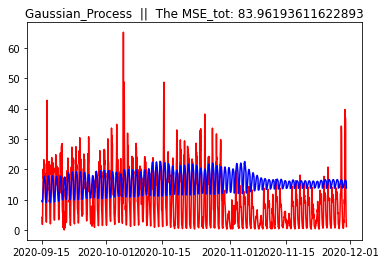

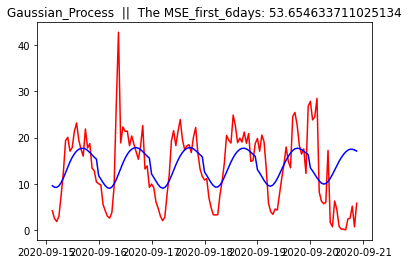

In [ ]:
count = 1
resume = []

for e in tq.tqdm(experiments) : 
  time.sleep(1)
  timestep = datetime.datetime.now().strftime('%Y-%m-%d %H_%M_%S')
  os.mkdir(os.path.join(os.getcwd(),model_name,timestep))
  x_train =  df_train[e].values
  x_test = df_test[e].values
  y_train = df_train[TARGET].values
  y_test = df_test[TARGET].values

  kernel = ConstantKernel() + Matern(length_scale=5, nu=3/2) + WhiteKernel(noise_level=100)
  n_restarts_optimizer = 1
  model = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer)

  model.fit(x_train,y_train)
  print("kernel: {}".format(model.kernel_))
  pred, sigma = model.predict(x_test, return_std=True)

  mse_tot = mean_squared_error(y_test,pred)
  mse_first = mean_squared_error(y_test[:24*6],pred[:24*6])
  record = {'name' : timestep , 'features' : e, "mse_tot":mse_tot , "mse_first" :mse_first , "kernel": model.kernel_, "path": os.path.join(os.getcwd(), model_name, timestep)}
  resume.append(record)
  pd.DataFrame.from_records([record]).to_csv(os.path.join(os.getcwd(),model_name,timestep,timestep+".csv"))
  fig = plt.figure(count)
  count = count + 1
  plt.plot(tt, y_test , color = 'r',label = 'real values')
  plt.plot(tt, pred , color ='b',label = 'prediected values')
  plt.title(model_name + "  ||  The MSE_tot: {}".format(mse_tot))
  fig.savefig(os.path.join(os.getcwd(),model_name,timestep,'total'+timestep+'.jpeg'))
  fig = plt.figure(count)
  count = count +1 
  plt.plot(tt[:24*6], y_test[:24*6] , color = 'r',label = 'real values')
  plt.plot(tt[:24*6], pred[:24*6] , color = 'b',label = 'predicted values')
  plt.title(model_name + "  ||  The MSE_first_6days: {}".format(mse_first))
  fig.savefig(os.path.join(os.getcwd(), model_name,timestep,'first'+timestep+'.jpeg'))
pd.DataFrame.from_records(resume).sort_values('mse_tot').to_csv(model_name+".csv")

In [ ]:
resume = pd.read_csv(model_name+'.csv')
del resume['Unnamed: 0']
resume

,name,features,mse_tot,mse_first,kernel,path
0,2020-12-09 00_18_39,"['weekday', 'weekofyear', 'month', 'year', 'ti...",83.961946,53.654659,"14.4**2 + Matern(length_scale=6.62, nu=1.5) + ...",/content/drive/My Drive/Dossier partagé avec ...


In [ ]:
resume['kernel']

0    14.4**2 + Matern(length_scale=6.62, nu=1.5) + ...
Name: kernel, dtype: object

In [ ]:
for i in range(1) : 
  print(i)
  print("MSE_tot: {}    ||     Features: {}".format( str(resume.loc[i,"mse_tot"]), resume.loc[i,'features']))

0
MSE_tot: 83.9619457664912    ||     Features: ['weekday', 'weekofyear', 'month', 'year', 'time', 'mean_taux_occupation_past_week']


name                                       2020-12-09 00_18_39
features     ['weekday', 'weekofyear', 'month', 'year', 'ti...
mse_tot                                                83.9619
mse_first                                              53.6547
kernel       14.4**2 + Matern(length_scale=6.62, nu=1.5) + ...
path         /content/drive/My Drive/Dossier partagé avec ...
Name: 0, dtype: object


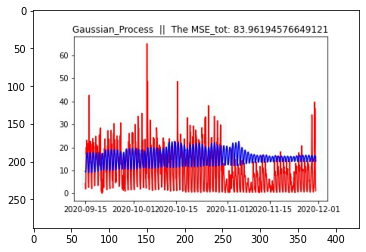

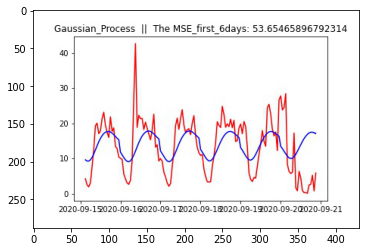

In [ ]:
for i in range(1) : 
  print(resume.loc[i])
  path = resume.loc[i,"path"]
  for file in os.listdir(path) : 
    if '.jpeg' in file : 
      img = mpimg.imread(os.path.join(resume.loc[i,'path'],file))
      plt.imshow(img)
      plt.show()